<a href="https://colab.research.google.com/github/Ray-Man05/Machine_Learning_Tutorials/blob/main/Spencer_RNN_Tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard Math / Data Libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web
import yfinance as yf
# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(2505)


# Cleaning the Data

In [18]:
# Daily Data on Gold
tick = 'GC=F'
# gold = web.get_data_yahoo(tick, '12/20/2015', interval='d')
# Getting the Adj Close column as well requires the parameter auto_adjust=False
# Notice how it's FALSE, not TRUE, that produces the desired result
gold = yf.download(tick, start='2020-02-26', interval='1d', auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [19]:
# Rearranging the columns so that Adj Close is the last one like in the tutorial
cols = list(gold.columns)[1:]
cols.append(gold.columns[0])
gold = gold[cols]
gold

Price,Close,High,Low,Open,Volume,Adj Close
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,,
2020-02-26,1640.000000,1648.099976,1636.400024,1644.000000,1990,1640.000000
2020-02-27,1640.000000,1658.000000,1638.500000,1641.099976,707,1640.000000
2020-02-28,1564.099976,1642.500000,1564.099976,1640.300049,289,1564.099976
2020-03-02,1592.300049,1608.300049,1574.300049,1583.900024,537,1592.300049
2020-03-03,1642.099976,1645.300049,1594.000000,1594.500000,610,1642.099976
...,...,...,...,...,...,...
2025-02-24,2947.899902,2957.899902,2933.100098,2933.100098,415,2947.899902
2025-02-25,2904.500000,2943.199951,2890.000000,2938.699951,1854,2904.500000


In [20]:
# This is how you might filter out data based on specific conditions, try it with tick = 'AAPL'
# The rows that do not verify the condition end up with NaN everywhere, you must use dropna() to clean up the result
# different_rows = gold[gold['Close'] - gold['Adj Close'] > 3]
# different_rows.dropna()

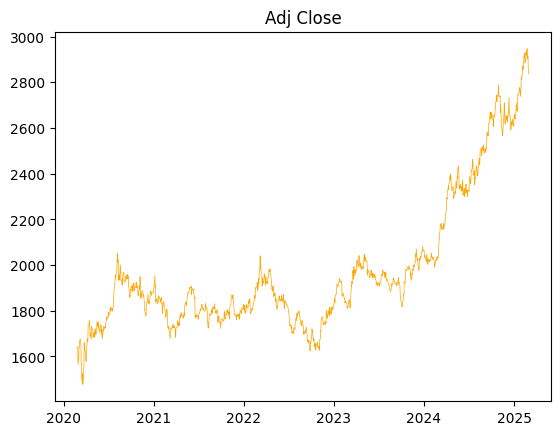

In [21]:
plt.title('Adj Close')
plt.plot(gold['Adj Close'] ,lw=0.5 ,color='orange')

In [22]:
returns = gold['Adj Close'].pct_change()
# Separating the data and the labels, similar to the network example in ihm
column_names = gold.columns
x = gold.values
# For each column, max value becomes 1, min value becomes 0, easier to deal with,
# values don't blow up or fizzle out as they get thru the neural network
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


In [23]:
pct_c_gold = df

In [24]:
pct_c_gold.columns = column_names

In [25]:
pct_c_gold

Price,Close,High,Low,Open,Volume,Adj Close
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,GC=F
0,0.110635,0.111337,0.124443,0.118056,0.009484,0.110635
1,0.110635,0.118054,0.125861,0.116097,0.003369,0.110635
2,0.059023,0.107538,0.075625,0.115556,0.001377,0.059023
3,0.078199,0.084334,0.082512,0.077443,0.002559,0.078199
4,0.112063,0.109438,0.095814,0.084606,0.002907,0.112063
...,...,...,...,...,...,...
1257,1.000000,1.000000,1.000000,0.989188,0.001978,1.000000
1258,0.970488,0.990026,0.970898,0.992972,0.008836,0.970488
1259,0.978852,0.972251,0.986428,0.975943,0.009770,0.978852


# Univariate Forecasting (RNN)

In [26]:
# Seen previously in returns = gold['Adj Close'].pct_change()
# The percentage change between consecutive values in the 'Adj Close' column
returns

Ticker,GC=F
Date,
2020-02-26,NaN
2020-02-27,0.000000
2020-02-28,-0.046281
2020-03-02,0.018030
2020-03-03,0.031275
...,...
2025-02-24,0.003506
2025-02-25,-0.014722
2025-02-26,0.004235


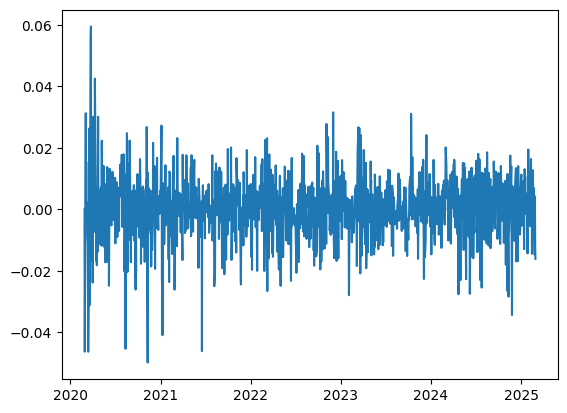

In [27]:
plt.plot(returns)

array([[<Axes: title={'center': 'GC=F'}>]], dtype=object)

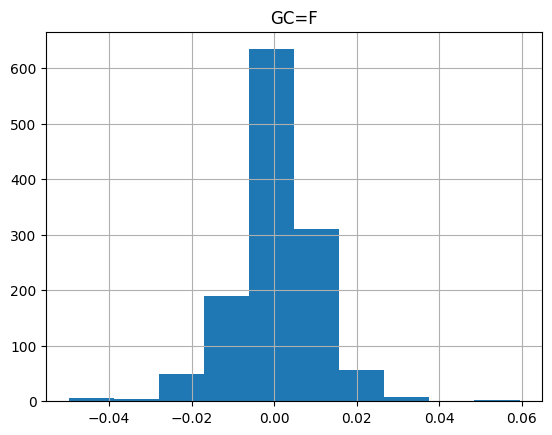

In [28]:
# Most changes are gonna be very slight
returns.hist()

In [29]:
# Reshaping the data into an n*1 matrix
# Numpy array = values of all of returns's columns except for the first one (row and column names)
# then reshape, python actually calculates how many dimensions it needs for the data based on the second parameter, based on the original dimensions of your shape
# -1 basically tells it, wait a sec, I'll give you the 'height' of the matrix, and you figure out what its 'length' should be
npa = returns.values[1:].reshape(-1,1)
print(len(npa))
# Scaling the data, again so it doesn't blow up or anything, (0,1) is actually the default value
scale = MinMaxScaler(feature_range=(0,1))
npa = scale.fit_transform(npa)
print(len(npa))

1261
1261




1.   Basically we'll use 10 'historical data points', to make predictions one step into the future
So taking the last 10 values of the adj cost here, try to predict the next one.

2.   Remember that we flattened the data into a 1d array
Since the num of prev samples needed for a prediction is 10, we can't predict anything for the first 10 entries.
So in the loop we're creating the *train_X* and *train_Y* values.


```
  For i in range 0..(size of data - 10):
    Append the first 10 data values to X_train
    Append the 11th data value to Y_train
```
3. At each index of X and Y the 10 values in X are the input and the value in Y is what the output should be.
Here we're just printing out the first of such pairs of input/output values to see what they look like.




In [30]:
# 1
samples = 10
steps = 1
X, Y = list(), list()
# 2
for i in range(npa.shape[0] - samples):
  X.append(npa[i:i+samples])
  Y.append(npa[i+samples][0])
# 3
print('Training Data: Length is ', len(X[0:1][0]), ':\n', X[0])
print('Testing Data: Length is ', len(Y[0:1]), ':\n', Y[0])
# Original code had X[0:1] and Y[0:1] instead of X[0] and Y[0]
# I don't see any change other than formatting, but keep that in mind

Training Data: Length is  10 :
 [[0.45566051]
 [0.03209438]
 [0.62066998]
 [0.74189829]
 [0.45008707]
 [0.59675481]
 [0.47982619]
 [0.47592775]
 [0.3714901 ]
 [0.35802166]]
Testing Data: Length is  1 :
 0.1651604395387659




1.   Notice how the size of the data is now 10 less than before, since we removed those first 10 entries.<br>
We also convert the basic vanilla python lists into numpy arrays that are more convenient to work with.
2.   Basically we're taking 90% of the data for training. The last 10% will be used for testing. Threshold is 0.9 times the size of data, rounded to the nearest int.



In [31]:
# 1
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)
# 2
threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (1251, 10, 1) Dimensions of Y (1251,)
Threshold is 1126


<h4>Building the actual RNN:</h4>
Where you can maximize the model's complexity and try to get the best results.
Things you can tune are the type of layers to use, how many units to implement, what type of activation functions to use, etc... <br>
Go read this for over/under fitting:
<a href="https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/" style="color: #04AA6D;">
  <button>
    geeksforgeeks
  </button>
</a>
You may in fact combine all the points 1 through 5 into a single constructor thingie to build your model, this is clearer though.

1.   Adding a RNN layer with 3 'hidden' units, units are those thingamajig  that take in the previous hidden state, like context type of stuff I guess, plus the current input, and does fancy math, then sends that stuff to the next hidden state.
2.   Adding a dropout layer. Basically telling it to forget about a random 20% of data each time.<hr>
This prevents *overfitting*, just blindly memorizing the training data, like a curve that squiggles all over the place to hit every coord of data, but doesn't represent the actual pattern.<hr>
Also prevents *underfitting*, so completely failing to see any pattern, like drawing a straight line that hits just enough coords to call it a day, but you don't capture the real pattern and miss out on the rest of the data.  
3.   A dense layer of 1 unit, apparently regression problems only require one unit in the output layer.<br>
No effing idea what this is about, just roll with it for now.
4. model.compile is a method that configures the model for training and sets the argments passed in, optimizer, loss function, metrics, eager execution.<br>
What you care about for now is mostly just the loss function, that's one of those so-called 'HyperParameters' you ought to tune, there's this mean_squared_error, categorical_crossentropy, and others.
See here <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses" style="color: #04AA6D;">
  <button>
    TensorFlow
  </button>
</a> <br>
Accuracy wasn't in the original code, added it to see what it'd look like.
5. Does what it says on the tin, take a look at the architecture of the model.



In [32]:
model = keras.Sequential()
# 1
model.add(layers.SimpleRNN(3,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(X.shape[1], X.shape[2])))
# 2
model.add(layers.Dropout(rate=0.2))

# 3
model.add(layers.Dense(1))

# 4
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# 5
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 3)                   │              15 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

Usually you just call model.fit, we're assigning the result to a variable called history to later on take a look at how the model evolved during its training.
1. Fit the training data (aka the threshold, 90% of what we started with).
Don't shuffle it since this is time series data. <br>
Go through the data 100 times. <br>
For each iteration through the data, feed the model 32 data points at a time. <br>
Set aside 20% of the training data as a validation during its training session. <br>
Gib more info plox.

In [33]:
# 1
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False,
                    epochs = 100,
                    batch_size = 32,
                    validation_split = 0.2,
                    verbose = 1
                    )

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0018 - loss: 0.0524 - val_accuracy: 0.0000e+00 - val_loss: 0.0135
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0060 - loss: 0.0408 - val_accuracy: 0.0000e+00 - val_loss: 0.0142
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0018 - loss: 0.0431 - val_accuracy: 0.0000e+00 - val_loss: 0.0140
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0018 - loss: 0.0376 - val_accuracy: 0.0000e+00 - val_loss: 0.0126
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0018 - loss: 0.0319 - val_accuracy: 0.0000e+00 - val_loss: 0.0116
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0018 - loss: 0.0294 - val_accuracy: 0.0000e+00 - val_loss: 0.0113
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0042 - loss: 0.0278 - val_accuracy: 0.0000e+00 - val_loss: 0.0110
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0042 - loss: 0.02

As a rule of thumb: <br>
**training loss >> validation loss -> Underfitting** <br>
**training loss << validation loss -> Overfitting**

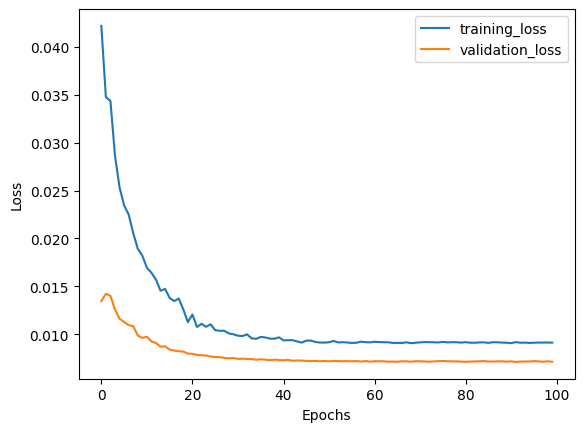

In [34]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Multi-Step Forecast

Multi-Step Forecast basically means using the model's predictions to make further predictions further into the future. <br>

1.   The rest of the values, after the threshold, are what we put aside for testing. true_Y are the actual irl values.<br>
pred_Y will be filled by the values our model predicts. <br>
Print Y_shape to see what it looks like.
Number of forecasts to do is really just the last 10% of the data, the test set.
2. Latest input is quite literally just that, the most recent X variable during testing, ie the values of the latest 10 days
3. Struggling to understand this, but the point is to use the X input to predict what Y should be, the value on the 11th day, then appending that prediction to the results.
Beyond that. <br>
Apparently the reshaping is format the input data into something the RNN expects. <br>
[0, 0] is to extract the actual predicted value from the output.
4. This here is important, it takes the last 9 data points, ie the latest 9 values, it appends the prediction 'p' we just made to the end of this array, then it uses that whole thing as the input of the next iteration. <hr>
Think of it like one of those cartoon trains, with the character frantically laying down train tracks just ahead of the moving train, except here, he's laying down tracks based on the ones the train just went through.

In [35]:
# testing_size = Y.shape[0] - round(Y.shape[0]*0.9)
# 1
true_Y = Y[threshold:]
pred_Y = list()
print('Number of Forecasts to do: ', Y.shape[0] - round(Y.shape[0]*0.9))
# 2
latest_input = X[threshold-1:threshold]
# 3
for i in range(Y.shape[0] -  round(Y.shape[0]*0.9)):
  p = model.predict(latest_input.reshape(1, X.shape[1], 1))[0, 0]
  pred_Y.append(p)
# 4
  latest_input = np.append(X[threshold][1:], p)

Number of Forecasts to do:  125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━